<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/3_imageClassification_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# dataset uploaded, it is already spilited by hand to train, test, valid, dev
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip3 install bcolz  

In [39]:
%cd /content/drive/MyDrive/dogVsCat

/content/drive/MyDrive/dogVsCat


In [40]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [42]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [43]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [44]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [45]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [46]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [47]:
train_ds = datasets.ImageFolder(train_dir)

In [48]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [49]:
sz =224
batch_size = 16

tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
])

train_ds = datasets.ImageFolder(train_dir, transform=tfms)
valid_ds = datasets.ImageFolder(validation_dir, transform=tfms)

In [50]:
len(train_ds), len(valid_ds)

(2000, 1000)

In [51]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


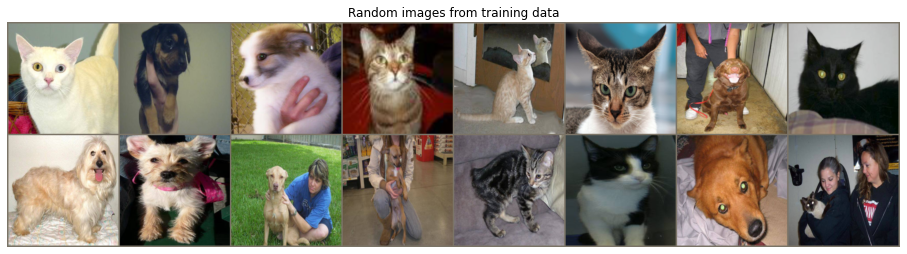

In [52]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

# Model:

In [53]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

In [54]:
model = SimpleCNN()

if use_gpu:
    model = model.cuda()

In [55]:
use_gpu

True

# loss Function

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Train

In [57]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/10], Step [ 50/125], Loss: 4.0386
Epoch [ 1/10], Step [100/125], Loss: 0.6872
Epoch [ 2/10], Step [ 50/125], Loss: 0.6663
Epoch [ 2/10], Step [100/125], Loss: 0.6739
Epoch [ 3/10], Step [ 50/125], Loss: 0.6870
Epoch [ 3/10], Step [100/125], Loss: 0.6191
Epoch [ 4/10], Step [ 50/125], Loss: 0.6119
Epoch [ 4/10], Step [100/125], Loss: 0.7147
Epoch [ 5/10], Step [ 50/125], Loss: 0.6797
Epoch [ 5/10], Step [100/125], Loss: 0.6427
Epoch [ 6/10], Step [ 50/125], Loss: 0.5254
Epoch [ 6/10], Step [100/125], Loss: 0.3779
Epoch [ 7/10], Step [ 50/125], Loss: 0.5024
Epoch [ 7/10], Step [100/125], Loss: 0.4400
Epoch [ 8/10], Step [ 50/125], Loss: 0.4506
Epoch [ 8/10], Step [100/125], Loss: 0.6869
Epoch [ 9/10], Step [ 50/125], Loss: 0.4659
Epoch [ 9/10], Step [100/125], Loss: 0.5272
Epoch [10/10], Step [ 50/125], Loss: 0.1243
Epoch [10/10], Step [100/125], Loss: 0.4378


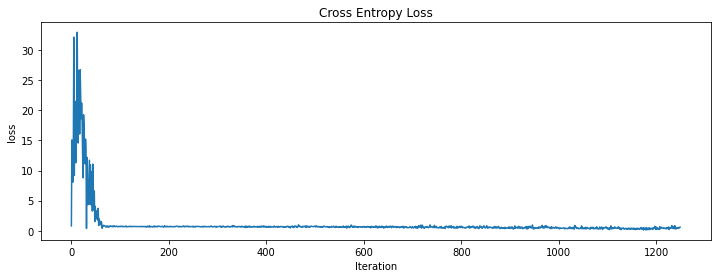

In [58]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

# Analayze results
## Accuracy on validation data

In [59]:
def evaluate_model(model, dataloader):
  model.eval()
  corrects = 0
  for inputs, targets in dataloader:
    inputs, targets = to_var(inputs, True), to_var(targets, True)
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    corrects += (preds == targets.data). sum()
  print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [60]:
evaluate_model(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 64.00


In [61]:
evaluate_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 92.35


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


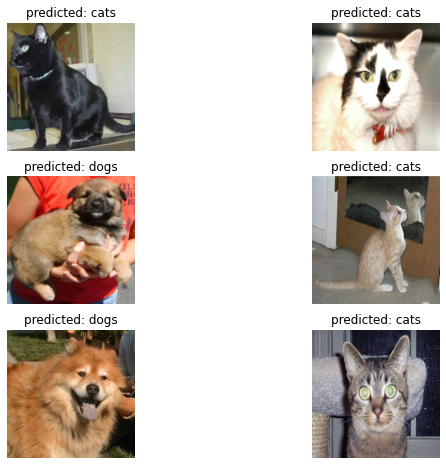

In [62]:
visualize_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


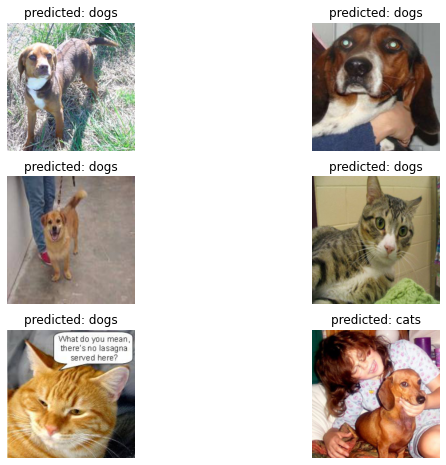

In [63]:
visualize_model(model, valid_dl)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 63/63 [00:05<00:00, 11.17it/s]


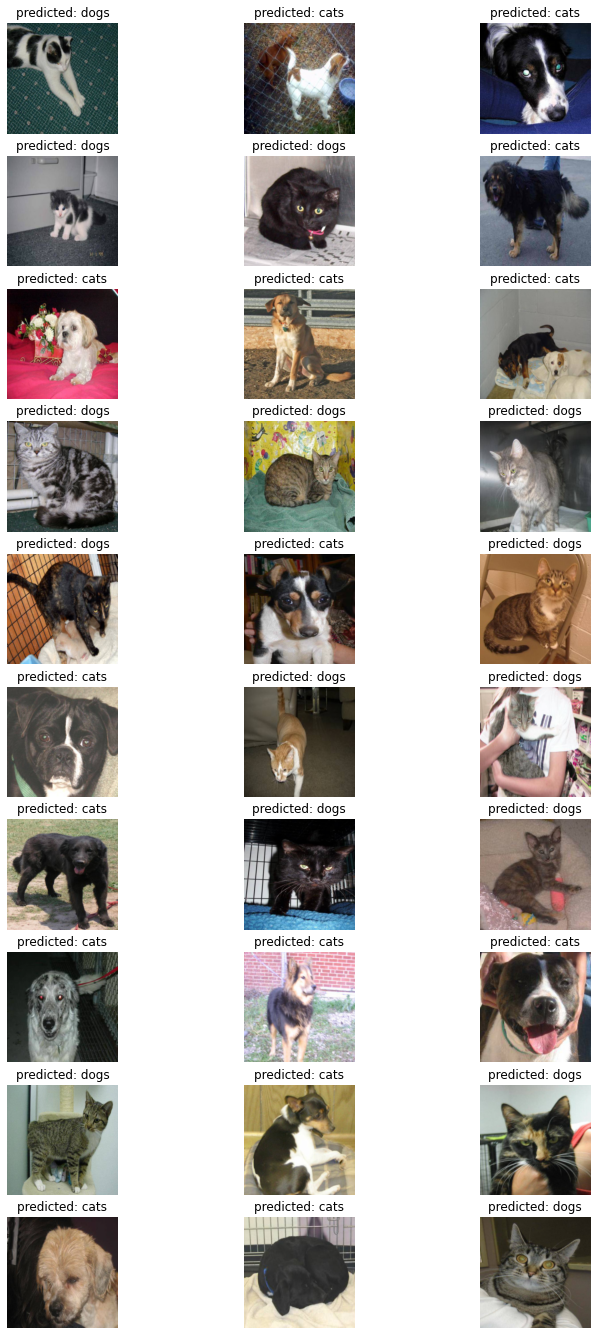

89 images out of 1000 were misclassified.


In [64]:
plot_errors(model, valid_dl)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 63/63 [00:04<00:00, 12.97it/s]


[[0.62 0.38]
 [0.34 0.66]]


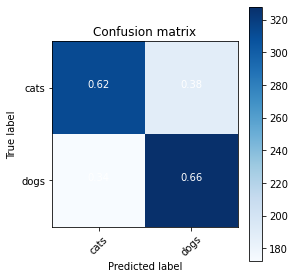

In [65]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4,4))